In [ ]:
#InfoGAN for cifar-10
# The approaches are the vectors can be concatenated beforehand and provided to a single input layer in the model
#The define_generator() function below defines the generator model and takes the size of the input vector as an argument.
#A fully connected layer takes the input vector and produces a sufficient number of activations to create 512 8×8 feature maps from which the activations are reshaped. 
#These then pass through a normal convolutional layer with 1×1 stride, then two subsequent upsamplings transpose convolutional layers with a 2×2 stride first to 14×14 feature maps then to the desired
# 1 channel 28×28 feature map output with pixel values in the range [-1,-1] via a tanh activation function.
#Good generator configuration heuristics are as follows, including a random Gaussian weight initialization, ReLU activations in the hidden layers, and use of batch normalization.

from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy import hstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Activation
from matplotlib import pyplot
from google.colab import drive
drive.mount('/content/drive') 
from google.colab import files 
# define the standalone discriminator model
def define_discriminator(n_cat, in_shape=(32,32,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.1)(d)
	# downsample to 7x7
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.1)(d)
	d = BatchNormalization()(d)
	# normal
	d = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.1)(d)
	d = BatchNormalization()(d)
	# flatten feature maps
	d = Flatten()(d)
	# real/fake output
	out_classifier = Dense(1, activation='sigmoid')(d)
	# define d model
	d_model = Model(in_image, out_classifier)
	# compile d model
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	# create q model layers
	q = Dense(128)(d)
	q = BatchNormalization()(q)
	q = LeakyReLU(alpha=0.1)(q)
	# q model output
	out_codes = Dense(n_cat, activation='softmax')(q)
	# define q model
	q_model = Model(in_image, out_codes)
	return d_model, q_model
 
# define the standalone generator model
def define_generator(gen_input_size):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image generator input
	in_lat = Input(shape=(gen_input_size,))
	# foundation for 7x7 image
	n_nodes = 512 * 8 * 8
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	gen = Reshape((8, 8, 512))(gen)
	# normal
	gen = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	# upsample to 14x14
	gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	# tanh output
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model
 
# define the combined discriminator, generator and q network model
def define_gan(g_model, d_model, q_model):
	# make weights in the discriminator (some shared with the q model) as not trainable
	d_model.trainable = False
	# connect g outputs to d inputs
	d_output = d_model(g_model.output)
	# connect g outputs to q inputs
	q_output = q_model(g_model.output)
	# define composite model
	model = Model(g_model.input, [d_output, q_output])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
	return model
 
# load images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape)
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images and labels
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_cat, n_samples):
	# generate points in the latent space
	z_latent = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_latent = z_latent.reshape(n_samples, latent_dim)
	# generate categorical codes
	cat_codes = randint(0, n_cat, n_samples)
	# one hot encode
	cat_codes = to_categorical(cat_codes, num_classes=n_cat)
	# concatenate latent points and control codes
	z_input = hstack((z_latent, cat_codes))
	return [z_input, cat_codes]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space and control codes
	z_input, _ = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, gan_model, latent_dim, n_cat, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0])
	# save plot to file
	
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	
  #plt.savefig(f"{images_dir}/abc.png")
	#pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the gan model
	filename3 = 'gan_model_%04d.h5' % (step+1)
	gan_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_cat, n_epochs=1, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator and q model weights
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_cat, half_batch)
		# update discriminator model weights
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# prepare points in latent space as input for the generator
		z_input, cat_codes = generate_latent_points(latent_dim, n_cat, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the g via the d and q error
		_,g_1,g_2 = gan_model.train_on_batch(z_input, [y_gan, cat_codes])
		# summarize loss on this batch
		print('>%d, d[%.3f,%.3f], g[%.3f] q[%.3f]' % (i+1, d_loss1, d_loss2, g_1, g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, gan_model, latent_dim, n_cat)
 
# number of values for the categorical control code
n_cat = 10
# size of the latent space
latent_dim = 100
# create the discriminator
d_model, q_model = define_discriminator(n_cat)
# create the generator
gen_input_size = latent_dim + n_cat
g_model = define_generator(gen_input_size)
# create the gan
gan_model = define_gan(g_model, d_model, q_model)
# load image data
dataset = load_real_samples()
# train model


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3, 1)


In [ ]:
def define_generator(gen_input_size):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image generator input
	in_lat = Input(shape=(gen_input_size,))
	# foundation for 7x7 image
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	gen = Reshape((8, 8, 128))(gen)
	# normal
	gen = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	# upsample to 14x14
	gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	# tanh output
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_latent = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_latent = z_latent.reshape(n_samples, latent_dim)
	# generate categorical codes
	cat_codes = randint(0, 10, n_samples)
	# one hot encode
	cat_codes = to_categorical(cat_codes,10)
	# concatenate latent points and control codes
	z_input = hstack((z_latent, cat_codes))
	return [z_input, cat_codes]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space and control codes
	z_input, _ = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y
g_model=define_generator(100)
X_fake, y_fake = generate_fake_samples(g_model, 90, 150)
print(X_fake.shape)

(150, 32, 32, 3)


In [ ]:
def define_gan(g_model, d_model, q_model):
	# make weights in the discriminator (some shared with the q model) as not trainable
	d_model.trainable = False
	# connect g outputs to d inputs
	d_output = d_model(g_model.output)
	# connect g outputs to q inputs
	q_output = q_model(g_model.output)
	# define composite model
	model = Model(g_model.input, [d_output, q_output])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
	return model
gan_model = define_gan(g_model, d_model, q_model)
print(g_model.output)

Tensor("activation_12/Tanh:0", shape=(None, None, None, 3), dtype=float32)


(50000, 32, 32, 3)
>1, d[0.794,0.844], g[0.859] q[0.000]
>2, d[0.794,0.826], g[0.869] q[0.000]
>3, d[0.836,0.833], g[0.861] q[0.000]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>2803, d[0.791,0.837], g[0.893] q[0.000]
>2804, d[0.827,0.842], g[0.823] q[0.000]
>2805, d[0.752,0.887], g[0.864] q[0.000]
>2806, d[0.801,0.873], g[0.866] q[0.000]
>2807, d[0.777,0.864], g[0.864] q[0.000]
>2808, d[0.809,0.838], g[0.892] q[0.000]
>2809, d[0.803,0.843], g[0.870] q[0.000]
>2810, d[0.809,0.843], g[0.841] q[0.000]
>2811, d[0.783,0.907], g[0.851] q[0.000]
>2812, d[0.792,0.891], g[0.894] q[0.000]
>2813, d[0.819,0.832], g[0.874] q[0.000]
>2814, d[0.770,0.832], g[0.883] q[0.000]
>2815, d[0.814,0.882], g[0.857] q[0.001]
>2816, d[0.762,0.854], g[0.924] q[0.000]
>2817, d[0.827,0.821], g[0.919] q[0.000]
>2818, d[0.848,0.833], g[0.851] q[0.000]
>2819, d[0.763,0.895], g[0.892] q[0.000]
>2820, d[0.809,0.840], g[0.907] q[0.000]
>2821, d[0.818,0.838], g[0.929] q[0.000]
>2822, d[0.839,0.858], g[0.884] q[0.000]
>2823, d[0.851,0.902], g[0.876] q[0.000]
>2824, d[0.809,0.851], g[0.904] q[0.000]
>2825, d[0.838,0.826], g[0.935] q[0.000]
>2826,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:159: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Streaming output truncated to the last 5000 lines.
>73004, d[0.897,0.831], g[0.976] q[0.000]
>73005, d[0.894,0.927], g[0.957] q[0.000]
>73006, d[0.888,0.902], g[0.939] q[0.000]
>73007, d[0.885,0.857], g[1.004] q[0.000]
>73008, d[0.917,0.877], g[0.951] q[0.000]
>73009, d[0.834,0.876], g[0.937] q[0.000]
>73010, d[0.909,0.914], g[0.946] q[0.000]
>73011, d[0.855,0.867], g[0.952] q[0.000]
>73012, d[0.919,0.945], g[0.885] q[0.041]
>73013, d[0.871,0.920], g[0.907] q[0.000]
>73014, d[0.837,0.903], g[0.937] q[0.000]
>73015, d[0.879,0.897], g[0.931] q[0.000]
>73016, d[0.874,0.908], g[0.909] q[0.000]
>73017, d[0.857,0.898], g[0.896] q[0.000]
>73018, d[0.838,0.989], g[0.959] q[0.000]
>73019, d[0.912,0.849], g[0.900] q[0.000]
>73020, d[0.894,0.927], g[0.906] q[0.000]
>73021, d[0.854,0.930], g[0.900] q[0.000]
>73022, d[0.850,0.888], g[0.930] q[0.001]
>73023, d[0.807,0.959], g[0.980] q[0.000]
>73024, d[0.928,0.862], g[0.936] q[0.000]
>73025, d[0.914,0.919], g[0.876] q[0.217]
>73026, d[0.870,0.910], g

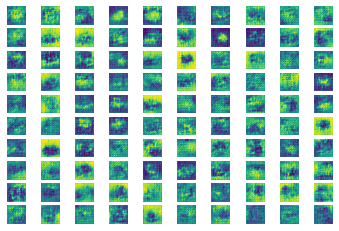

In [ ]:


def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X  
dataset = load_real_samples() 
print(dataset.shape)	
  # calculate the number of batches per training epoch
bat_per_epo = int(dataset.shape[0] / 128)
	# calculate the number of training iterations
n_steps = bat_per_epo * 200
	# calculate the size of half a batch of samples
half_batch = int(128 / 2)
	# manually enumerate epochs
for i in range(n_steps):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator and q model weights
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(g_model, 90, 150)
		# update discriminator model weights
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# prepare points in latent space as input for the generator
		z_input, cat_codes = generate_latent_points(90, 128)
		# create inverted labels for the fake samples
		y_gan = ones((128, 1))
		# update the g via the d and q error
		_,g_1,g_2 = gan_model.train_on_batch(z_input, [y_gan, cat_codes])
		# summarize loss on this batch
		print('>%d, d[%.3f,%.3f], g[%.3f] q[%.3f]' % (i+1, d_loss1, d_loss2, g_1, g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, gan_model, 90, 10)
 


		

